In [103]:
#see https://subscription.packtpub.com/book/application-development/9781783984985/4/ch04lvl1sec75/converting-a-map-coordinate-to-a-pixel-location

from osgeo import gdal

def world2Pixel(geoMatrix, x, y):
  ulX = geoMatrix[0]
  ulY = geoMatrix[3]
  xDist = geoMatrix[1]
  yDist = geoMatrix[5]
  rtnX = geoMatrix[2]
  rtnY = geoMatrix[4]
  pixel = int((x - ulX) / xDist)
  line = int((y - ulY) / yDist)
  return (pixel, line)

src = gdal.Open("wc2.1_2.5m_prec_2010-2018/wc2.1_2.5m_prec_2010-01.tif")

geoTrans = src.GetGeoTransform()

world2Pixel(geoTrans, 87.42445, 48.57034)

#arrays to use for input data
Precip = []
T_air = []
SWE = [0]

In [104]:
# https://gis.stackexchange.com/questions/346288/extract-all-pixels-values-from-geotiff-with-python

import rasterio
import random

p_data = ['wc2.1_2.5m_prec_2010-2018/wc2.1_2.5m_prec_2010-10.tif',
         'wc2.1_2.5m_prec_2010-2018/wc2.1_2.5m_prec_2010-11.tif',
         'wc2.1_2.5m_prec_2010-2018/wc2.1_2.5m_prec_2010-12.tif',
         'wc2.1_2.5m_prec_2010-2018/wc2.1_2.5m_prec_2011-01.tif',
         'wc2.1_2.5m_prec_2010-2018/wc2.1_2.5m_prec_2011-02.tif',
         'wc2.1_2.5m_prec_2010-2018/wc2.1_2.5m_prec_2011-03.tif',
         'wc2.1_2.5m_prec_2010-2018/wc2.1_2.5m_prec_2011-04.tif',
         'wc2.1_2.5m_prec_2010-2018/wc2.1_2.5m_prec_2011-05.tif']

t_data = ['wc2.1_2.5m_tmax_2010-2018/wc2.1_2.5m_tmax_2010-10.tif',
         'wc2.1_2.5m_tmax_2010-2018/wc2.1_2.5m_tmax_2010-11.tif',
         'wc2.1_2.5m_tmax_2010-2018/wc2.1_2.5m_tmax_2010-12.tif',
         'wc2.1_2.5m_tmax_2010-2018/wc2.1_2.5m_tmax_2011-01.tif',
         'wc2.1_2.5m_tmax_2010-2018/wc2.1_2.5m_tmax_2011-02.tif',
         'wc2.1_2.5m_tmax_2010-2018/wc2.1_2.5m_tmax_2011-03.tif',
         'wc2.1_2.5m_tmax_2010-2018/wc2.1_2.5m_tmax_2011-04.tif',
         'wc2.1_2.5m_tmax_2010-2018/wc2.1_2.5m_tmax_2011-05.tif']

d_data = [31,30,31,31,28,31,30,31] #number of days in each month

band_id = 1  # this assumes you want the first band, change to match the band number you want

for i in range(0, len(p_data)):

    #need to allocate the monthly data to the number of days in the month
    num_days = int(d_data[i])

    raster = rasterio.open(p_data[i])
    band_arr = raster.read(band_id)  # band_arr is a numpy array of shape (raster.width, raster.height)

    precip_value = band_arr[994, 6418]

    raster = rasterio.open(t_data[i])
    band_arr = raster.read(band_id)  # band_arr is a numpy array of shape (raster.width, raster.height)

    tmax_value = band_arr[994, 6418]

    for i in range(0, num_days):
        Precip.append(precip_value/num_days)

    for i in range(0, num_days):
        T_air.append(tmax_value + float(random.randint(-70, 71))/10.0)

    for i in range(0, num_days):
        SWE.append(0)


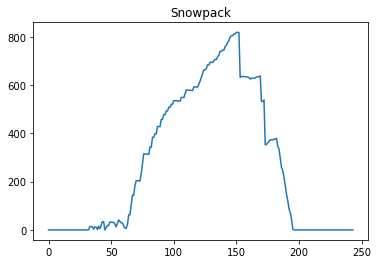

In [105]:
# see: https://www.hec.usace.army.mil/confluence/hmsdocs/hmsguides/modeling-snowmelt/using-the-snowmelt-modeling-capabilities-within-hec-hms

import matplotlib.pyplot as plt

#calculate snowpack based on weather data

#T_air = [0, -2, -2, -5, 0, 0, -12, -14, -8, -7, -10, -2, -3, 0, 1, 5, 4, 2, 8, -1, -2, 4]
#Precip = [0, 2, 12, 6, 0, 0, 12, 14, 28, 27, 10, 2, 3, 0, 11, 5, 4, 12, 8, 1, 2, 4]
#SWE = [50, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# dSWE = P - R + V + B, where:

# d = change in
# SWE = Snow Water Equivalent
# P = Precipitation contribution (see rain-to-snow multiplier table below)
# R = Run off (determined by phase change in the snowpack which is determined through the energy balance calculations)
# V = mass gained by water Vapor (can be negative)
# B = mass gained by Blowing snow (can be negative)

# The melt rate for dry conditions typically ranges from 1 to 4 mm/degC-day

rain_to_snow = [
   #Tmin, Tmax, multiplier 
    [1, 40, 0],
    [-2.8, 1, 10],
    [-6.7, -2.8, 15],
    [-9.5, -6.7, 20],
    [-12.2, -9.5, 30],
    [-17.8, -12.2, 40],
    [-28.9, -17.8, 50],
    [-60, -28.9, 100]]

for i in range(0, len(Precip)):
    
    P = Precip[i]
    
    for r in range(0, len(rain_to_snow)):
        if (T_air[i] >= rain_to_snow[r][0]):
            if (T_air[i] < rain_to_snow[r][1]):
                P = Precip[i]*rain_to_snow[r][2]              

    if(random.randint(0,100) < 40):
        P = 0
    
    R = 0
    if T_air[i] > 0:
        if P == 0:
            R = T_air[i] * 2.5
        else:
            R = T_air[i] * 200.0
    else:
        R = 0.5

    SWE[i+1] = SWE[i] + P - R
    
    if(SWE[i+1] < 0):
        SWE[i+1] = 0

#plot the stock's performance
plt.plot(SWE)
plt.title('Snowpack')

plt.show()